In [60]:
# !pip install mlflow dagshub
import zipfile
import os
import matplotlib.pylab as plt
import mlflow
import mlflow.keras
import dagshub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Activation,BatchNormalization,Dropout,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# Navigate to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/Human_Action_Recognition.zip'

# Extract the dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

dataset_path = '/content/dataset/'
print("Root contents:", os.listdir(dataset_path))

# Explore the structured folder
structured_path = '/content/dataset/Structured'
print("\nStructured folder contents:", os.listdir(structured_path))

# Check train and test folders
train_path = os.path.join(structured_path, 'train')
test_path = os.path.join(structured_path, 'test')

print(f"\nTrain folder contents: {os.listdir(train_path)}")
print(f"Test folder contents: {os.listdir(test_path)}")

Root contents: ['Structured']

Structured folder contents: ['test', 'train']

Train folder contents: ['running', 'clapping', 'calling', 'cycling', 'hugging', 'texting', 'using_laptop', 'sitting', 'eating', 'drinking', 'fighting', 'sleeping', 'dancing', 'laughing', 'listening_to_music']
Test folder contents: ['running', 'clapping', 'calling', 'cycling', 'hugging', 'texting', 'using_laptop', 'sitting', 'eating', 'drinking', 'fighting', 'sleeping', 'dancing', 'laughing', 'listening_to_music']


In [48]:
def create_action_recognition_dataset():
    structured_path = '/content/dataset/Structured'
    train_path = os.path.join(structured_path, 'train')
    test_path = os.path.join(structured_path, 'test')

    # Automatically discover class names from train folder
    CLASS_NAMES = sorted(os.listdir(train_path))
    print("Discovered action classes:", CLASS_NAMES)

    # Create datasets using Keras - this is much simpler!
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_path,
        labels='inferred',
        label_mode='int',
        class_names=CLASS_NAMES,
        image_size=(128, 128),
        batch_size=32,
        shuffle=True
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_path,
        labels='inferred',
        label_mode='int',
        class_names=CLASS_NAMES,
        image_size=(128, 128),
        batch_size=32,
        shuffle=False
    )

    return train_dataset, test_dataset, CLASS_NAMES

# Create the datasets
train_dataset, test_dataset, CLASS_NAMES = create_action_recognition_dataset()

print(f"\nDataset created successfully!")
print(f"Number of classes: {len(CLASS_NAMES)}")
print(f"Classes: {CLASS_NAMES}")
print(f"Train batches: {len(train_dataset)}")
print(f"Test batches: {len(test_dataset)}")

Discovered action classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Found 10710 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.

Dataset created successfully!
Number of classes: 15
Classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Train batches: 335
Test batches: 60


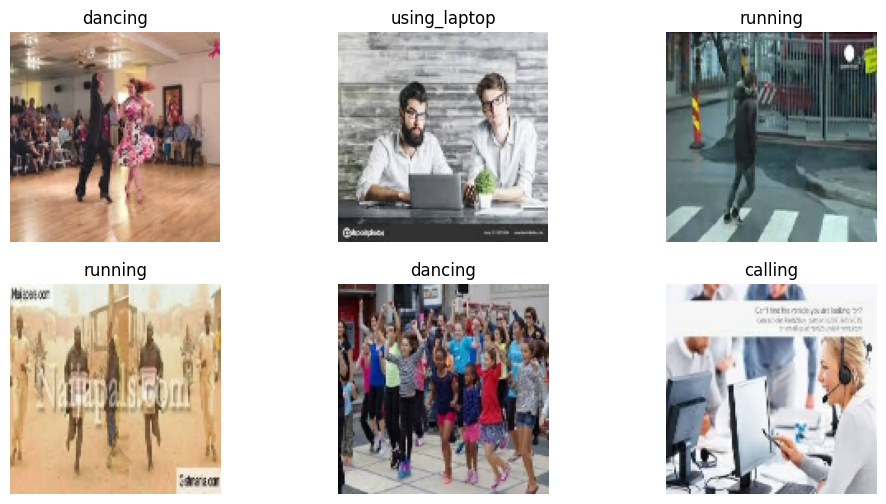

In [49]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis('off')
    plt.show()

In [50]:
def plot_training(history):
    """Simple plot function"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()

    plt.show()

In [51]:
DAGSHUB_USERNAME = "Arej02"
DAGSHUB_REPO_NAME = "Human_Action_Recognition"

# Setup DagsHub connection
dagshub.init(repo_owner=DAGSHUB_USERNAME, repo_name=DAGSHUB_REPO_NAME,mlflow=True)

# Set MLflow tracking to DagsHub
mlflow.set_tracking_uri(f"https://dagshub.com/Arej02/Human_Action_Recognition.mlflow")

Initialized MLflow to track repo "Arej02/Human_Action_Recognition"

Repository Arej02/Human_Action_Recognition initialized!

In [52]:
def train_action_recognition():

  with mlflow.start_run(run_name="baseline_model"):
    train_dataset, test_dataset, CLASS_NAMES = create_action_recognition_dataset()

    print(f"Training model for {len(CLASS_NAMES)} action classes")
    print(f"Training samples: {len(train_dataset) * 32}")
    print(f"Testing samples: {len(test_dataset) * 32}")

    # Log parameters:
    mlflow.log_params({
        "image_size":128,
        "batch_size":32,
        "epochs":10,
        "model_type":"baseline_cnn",
        "optimizer":"adam",
        "loss": "sparse_categorical_crossentropy",
        "num_classes": len(CLASS_NAMES),
        "architecture": "CNN_3blocks"
    })

    # Log model architecture parameters
    mlflow.log_params({
        "conv1_filters": 32,
        "conv2_filters": 64,
        "conv3_filters": 128,
        "dense1_units": 64,
        "dense2_units": 128,
        "dropout_rate": 0.5,
        "batch_norm": True
        })

    model=Sequential([

        # First Conv Block:
        Conv2D(32,(3,3),input_shape=(128,128,3),activation="relu"),
        MaxPooling2D((2,2)),

        # Second Conv Block:
        Conv2D(64,(3,3),activation="relu"),
        MaxPooling2D((2,2)),

        # Third Conv Block:
        Conv2D(128,(3,3),activation="relu"),
        MaxPooling2D((2,2)),

        Flatten(),

        #Layer 1
        Dense(64),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.5),

        #Layer 2
        Dense(128),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.5),

        #OutputLayer
        Dense(len(CLASS_NAMES),activation="softmax")
    ])

    model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
    model.summary()

    history=model.fit(train_dataset,validation_data=test_dataset,epochs=10)

    # Log final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    mlflow.log_metrics({
        "final_train_accuracy": final_train_acc,
        "final_val_accuracy": final_val_acc,
        "final_train_loss": final_train_loss,
        "final_val_loss": final_val_loss
        })

    plot_training(history)

    return history, model

Discovered action classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Found 10710 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.
Training model for 15 action classes
Training samples: 10720
Testing samples: 1920


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,709,967 (6.52 MB)

 Trainable params: 1,709,583 (6.52 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.0849 - loss: 3.0939 - val_accuracy: 0.1354 - val_loss: 2.5786
Epoch 2/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.1336 - loss: 2.6706 - val_accuracy: 0.1984 - val_loss: 2.4201
Epoch 3/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.1781 - loss: 2.5052 - val_accuracy: 0.2640 - val_loss: 2.2949
Epoch 4/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.2124 - loss: 2.3810 - val_accuracy: 0.2709 - val_loss: 2.2437
Epoch 5/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.2512 - loss: 2.2757 - val_accuracy: 0.3032 - val_loss: 2.1614
Epoch 6/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.2871 - loss: 2.1932 - val_accuracy: 0.2884 - val_loss: 2.1910
Epoch 7/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.2951 - loss: 2.1145 - val_accuracy: 0.3275 - val_loss: 2.0594
Epoch 8/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.3386 - loss: 2.0373 - val_a

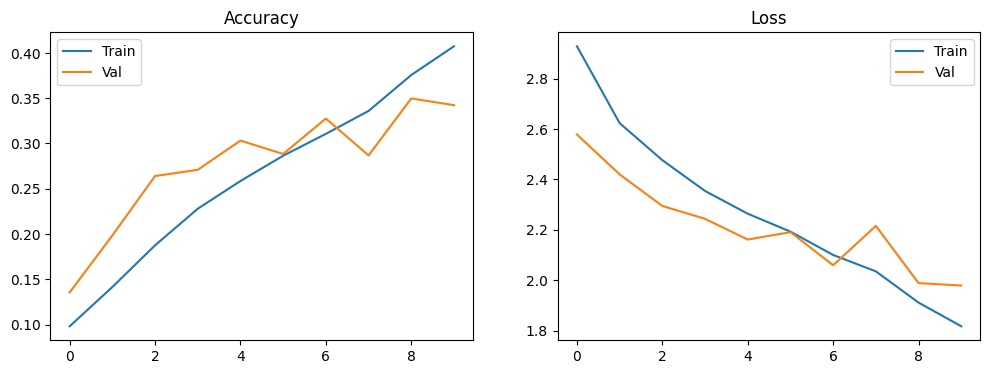

🏃 View run baseline_model at: https://dagshub.com/Arej02/Human_Action_Recognition.mlflow/#/experiments/0/runs/bea0e1df09534cf3abdf0ded3b4d22c1
🧪 View experiment at: https://dagshub.com/Arej02/Human_Action_Recognition.mlflow/#/experiments/0
Final training accuracy: 0.4074
Final validation accuracy: 0.3423


In [53]:
def main():

  history, model = train_action_recognition()

  print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
  print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

if __name__ == "__main__":
    main()

### Changing the Dropout:

In [61]:
def train_larger_capacity():

  with mlflow.start_run(run_name="overfitting_model"):
    train_dataset, test_dataset, CLASS_NAMES = create_action_recognition_dataset()

    print(f"Training model for {len(CLASS_NAMES)} action classes")
    print(f"Training samples: {len(train_dataset) * 32}")
    print(f"Testing samples: {len(test_dataset) * 32}")

    # Log parameters:
    mlflow.log_params({
        "strategy":"increased_capacity"
    })


    model=Sequential([

        # Larger First Conv Block:
        Conv2D(64,(3,3),input_shape=(128,128,3),activation="relu"),
        Conv2D(64,(3,3),activation="relu"),
        MaxPooling2D((2,2)),

        # Second Conv Block:
        Conv2D(128,(3,3),activation="relu"),
        Conv2D(128,(3,3),activation="relu"),
        MaxPooling2D((2,2)),

        # Third Conv Block:
        Conv2D(256,(3,3),activation="relu"),
        Conv2D(256,(3,3),activation="relu"),
        MaxPooling2D((2,2)),

        # Additional conv block
        Conv2D(512, (3,3), activation="relu"),

        GlobalAveragePooling2D(),

        #Layer 1
        Dense(64),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.3),

        #Layer 2
        Dense(128),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.3),

        #OutputLayer
        Dense(len(CLASS_NAMES),activation="softmax")
    ])

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=["accuracy"])
    model.summary()

    history=model.fit(train_dataset,validation_data=test_dataset,epochs=10)

    # Log final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    mlflow.log_metrics({
        "final_train_accuracy": final_train_acc,
        "final_val_accuracy": final_val_acc,
        "final_train_loss": final_train_loss,
        "final_val_loss": final_val_loss
        })

    plot_training(history)

    return history, model

Discovered action classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Found 10710 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.
Training model for 15 action classes
Training samples: 10720
Testing samples: 1920


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 58, 58, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,369,423 (9.04 MB)

 Trainable params: 2,369,039 (9.04 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 53s 129ms/step - accuracy: 0.0922 - loss: 2.9734 - val_accuracy: 0.0730 - val_loss: 4.4363
Epoch 2/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 33s 100ms/step - accuracy: 0.1334 - loss: 2.7294 - val_accuracy: 0.1254 - val_loss: 3.1053
Epoch 3/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 35s 103ms/step - accuracy: 0.1447 - loss: 2.6604 - val_accuracy: 0.0788 - val_loss: 4.2529
Epoch 4/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 34s 100ms/step - accuracy: 0.1632 - loss: 2.6003 - val_accuracy: 0.1820 - val_loss: 2.5338
Epoch 5/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 34s 100ms/step - accuracy: 0.1767 - loss: 2.5289 - val_accuracy: 0.2180 - val_loss: 2.3763
Epoch 6/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 34s 103ms/step - accuracy: 0.1875 - loss: 2.4926 - val_accuracy: 0.1926 - val_loss: 2.4198
Epoch 7/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 34s 100ms/step - accuracy: 0.2055 - loss: 2.4391 - val_accuracy: 0.2138 - val_loss: 2.3116
Epoch 8/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 34s 101ms/step - accuracy: 0.2190 - loss: 2

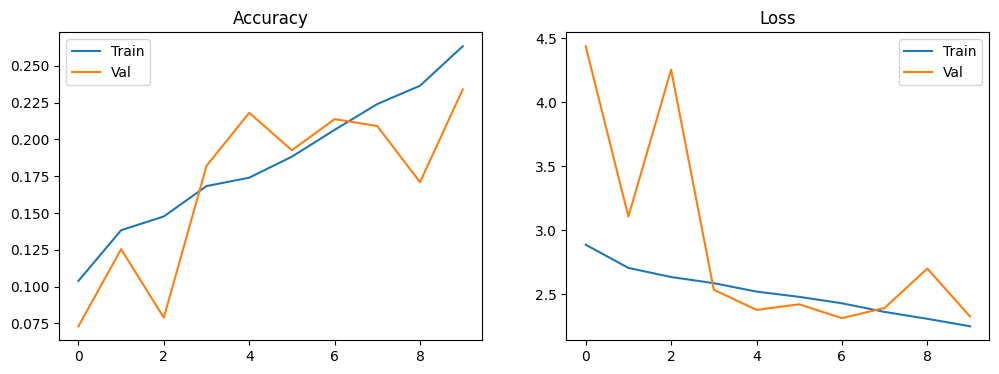

🏃 View run overfitting_model at: https://dagshub.com/Arej02/Human_Action_Recognition.mlflow/#/experiments/0/runs/b86dc72755c1444a91ab3d22832bccca
🧪 View experiment at: https://dagshub.com/Arej02/Human_Action_Recognition.mlflow/#/experiments/0
Final training accuracy: 0.2632
Final validation accuracy: 0.2339


In [62]:
def main():

  history, model = train_larger_capacity()

  print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
  print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

if __name__ == "__main__":
    main()